This notebook demonstrates coarse-graining of omega and temperature in the lowest model layer over ocean. It shows that our current pressure-level coarse-graining strategy leads to somewhat odd behavior in the lowest model layer over ocean where we tend to mask about half the cells when doing coarse-graining (specifically we mask those with lower surface pressure than the coarse-cell-mean surface pressure). This leads to large values of omega in the lowest model layer, and up to 1 K differences in lowest layer temperature. We think this effect is part of what is leading to very large apparent source of heating in the lowest model layer over regions of oceanic convection.

In [58]:
import xarray as xr
import fsspec
import cartopy.crs as ccrs
from dask.distributed import Client
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 400
from vcm.fv3.metadata import gfdl_to_standard, standardize_fv3_diagnostics
from vcm.cubedsphere.regridz import regrid_to_area_weighted_pressure
from vcm.cubedsphere.coarsen import block_upsample_like
from vcm.catalog import catalog
import vcm
import loaders
from loaders.mappers._fine_res_budget import eddy_flux_coarse
import string
xr.set_options(keep_attrs=True)

In [59]:
Client()

/home/OliWM/miniconda3/envs/fv3net/lib/python3.8/site-packages/distributed/dashboard/core.py:20: UserWarning: 
Dask needs bokeh >= 2.4.2, < 3 for the dashboard.
You have bokeh==2.2.3.
Continuing without the dashboard.
  warnings.warn(
/home/OliWM/miniconda3/envs/fv3net/lib/python3.8/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46441 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:33255' processes=4 threads=8, memory=29.39 GiB>

In [60]:
url_dycore = 'gs://vcm-ml-raw-flexible-retention/2022-06-27-C3072-snapshot/atmos_15min_ave.zarr'
url_physics = 'gs://vcm-ml-raw-flexible-retention/2022-06-27-C3072-snapshot/gfsphysics_15min.zarr'
url_grid = 'gs://vcm-ml-data/2019-12-12-C3072-model-native-grid-spec.zarr'
url_c3072_sfc = 'gs://vcm-ml-data/2019-12-04-C3072-restart-files-2016-08-16-00/sfc_data.zarr'
url_delp = 'gs://vcm-ml-raw-flexible-retention/2023-01-30-C3072-reuploaded-diagnostics/delp_raw_dt_atmos.zarr'
land_sea_mask_c48 = catalog['landseamask/c48'].to_dask().load()
grid_c384 = catalog['grid/c384'].to_dask().load()
grid_c48 = catalog['grid/c48'].to_dask().load()
PLOT_TILE = 3
PLOT_TIME = '2016-08-11T00:15:00'
PLOT_KWARGS = dict(x='y', yincrease=False)


In [61]:
def open_zarr(url, average_time=False):
    ds = xr.open_zarr(fsspec.get_mapper(url))
    if average_time:
        ds = ds.mean('time')
    else:    
        ds = ds.isel(time=0).drop('time')
    return gfdl_to_standard(ds)

In [62]:
ds_dycore = open_zarr(url_dycore)
ds_physics = open_zarr(url_physics)
grid = open_zarr(url_grid)
delp = open_zarr(url_delp, average_time=True)
lsmsk = gfdl_to_standard(xr.open_zarr(url_c3072_sfc).slmsk.isel(Time=0)).rename(xaxis_1='x', yaxis_1='y')
ds = xr.merge([delp.delp_raw.rename('delp'), ds_dycore, ds_physics, lsmsk], compat='override').assign_coords(z=range(79))


<ipython-input-61-3315ccbc3b88>:2: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds = xr.open_zarr(fsspec.get_mapper(url))


In [63]:
VARIABLES = ['temp', 'vulcan_omega']

In [64]:
# model-level coarse-grain from C3072 to C48
ds_area_weighted = vcm.cubedsphere.weighted_block_average(
    ds[VARIABLES + ['delp']],
    grid.area,
    64,
    x_dim='x',
    y_dim='y',
)

# regrid from C3072 to C48 pressure levels
regridded, masked_area = regrid_to_area_weighted_pressure(
    ds[VARIABLES],
    ds.delp,
    grid.area,
    64,
    x_dim='x',
    y_dim='y',
    z_dim='z',
)

# pressure-level coarse-grain from C3072 to C48 using masked area
ds_pressure_one_step = vcm.cubedsphere.weighted_block_average(
    regridded,
    masked_area,
    64,
    x_dim='x',
    y_dim='y',
)

# pressure-level coarse-grain from C3072 to C48 using unmasked area
ds_pressure_one_step_unmasked = vcm.cubedsphere.weighted_block_average(
    regridded,
    grid.area,
    64,
    x_dim='x',
    y_dim='y',
)

In [65]:
ds['pressure'] = vcm.pressure_at_midpoint_log(ds.delp, dim='z')
ds_area_weighted['pressure'] = vcm.pressure_at_midpoint_log(ds_area_weighted.delp, dim='z')
ds['surface_pressure'] = vcm.surface_pressure_from_delp(ds.delp).compute()
ds_area_weighted['surface_pressure'] = vcm.surface_pressure_from_delp(ds_area_weighted.delp)

In [66]:
ds['c48_pressure'] = block_upsample_like(ds_area_weighted.pressure, ds.pressure, x_dim='x', y_dim='y')
ds['c48_surface_pressure'] = block_upsample_like(ds_area_weighted.surface_pressure, ds.surface_pressure, x_dim='x', y_dim='y')
ds['c48_land_sea_mask'] = block_upsample_like(land_sea_mask_c48.land_sea_mask, ds.surface_pressure, x_dim='x', y_dim='y')


/home/OliWM/miniconda3/envs/fv3net/lib/python3.8/site-packages/xarray/core/dataset.py:2145: FutureWarning: None value for 'chunks' is deprecated. It will raise an error in the future. Use instead '{}'
  warnings.warn(


In [67]:
# compute coarse-grained temperature and omega at lowest model layer
for variable in ['temp', 'vulcan_omega']:
    print(variable)
    for i, tmp in enumerate([ds_area_weighted, ds_pressure_one_step, ds_pressure_one_step_unmasked]):
        print(i)
        for tile in [3]:
            print(tile)
            tmp[f'{variable}_computed_tile{tile}'] = tmp[variable].isel(z=-1, tile=tile).compute()

temp
0
3
1
3
2
3
vulcan_omega
0
3
1
3
2
3


In [68]:
def plot_pcolormesh(ax, lon, lat, da, **kwargs):
    pm = ax.pcolormesh(lon, lat, da, transform=ccrs.PlateCarree(), **kwargs)
    ax.set_extent([126, 138, 10, 22], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True, alpha=0.2)
    gl.right_labels = False
    gl.top_labels = False
    units = da.attrs.get('units', '')
    label = da.attrs.get('long_name', da.name) + f' [{units}]'
    cb = plt.colorbar(pm, ax=ax, label=label)

In [69]:
ds['surface_pressure_hPa'] = (ds.surface_pressure / 100).assign_attrs(units='hPa')

In [70]:
masked_area = masked_area.assign_attrs(long_name='masked cell area')
ds['vulcan_omega'] = ds.vulcan_omega.assign_attrs(long_name='omega')
ds_pressure_one_step['vulcan_omega_computed_tile3'] = ds_pressure_one_step['vulcan_omega_computed_tile3'].assign_attrs(long_name='omega')
ds_pressure_one_step_unmasked['vulcan_omega_computed_tile3'] = ds_pressure_one_step_unmasked['vulcan_omega_computed_tile3'].assign_attrs(long_name='omega')

### Plot C3072 surface pressure, coarsening weights and omega

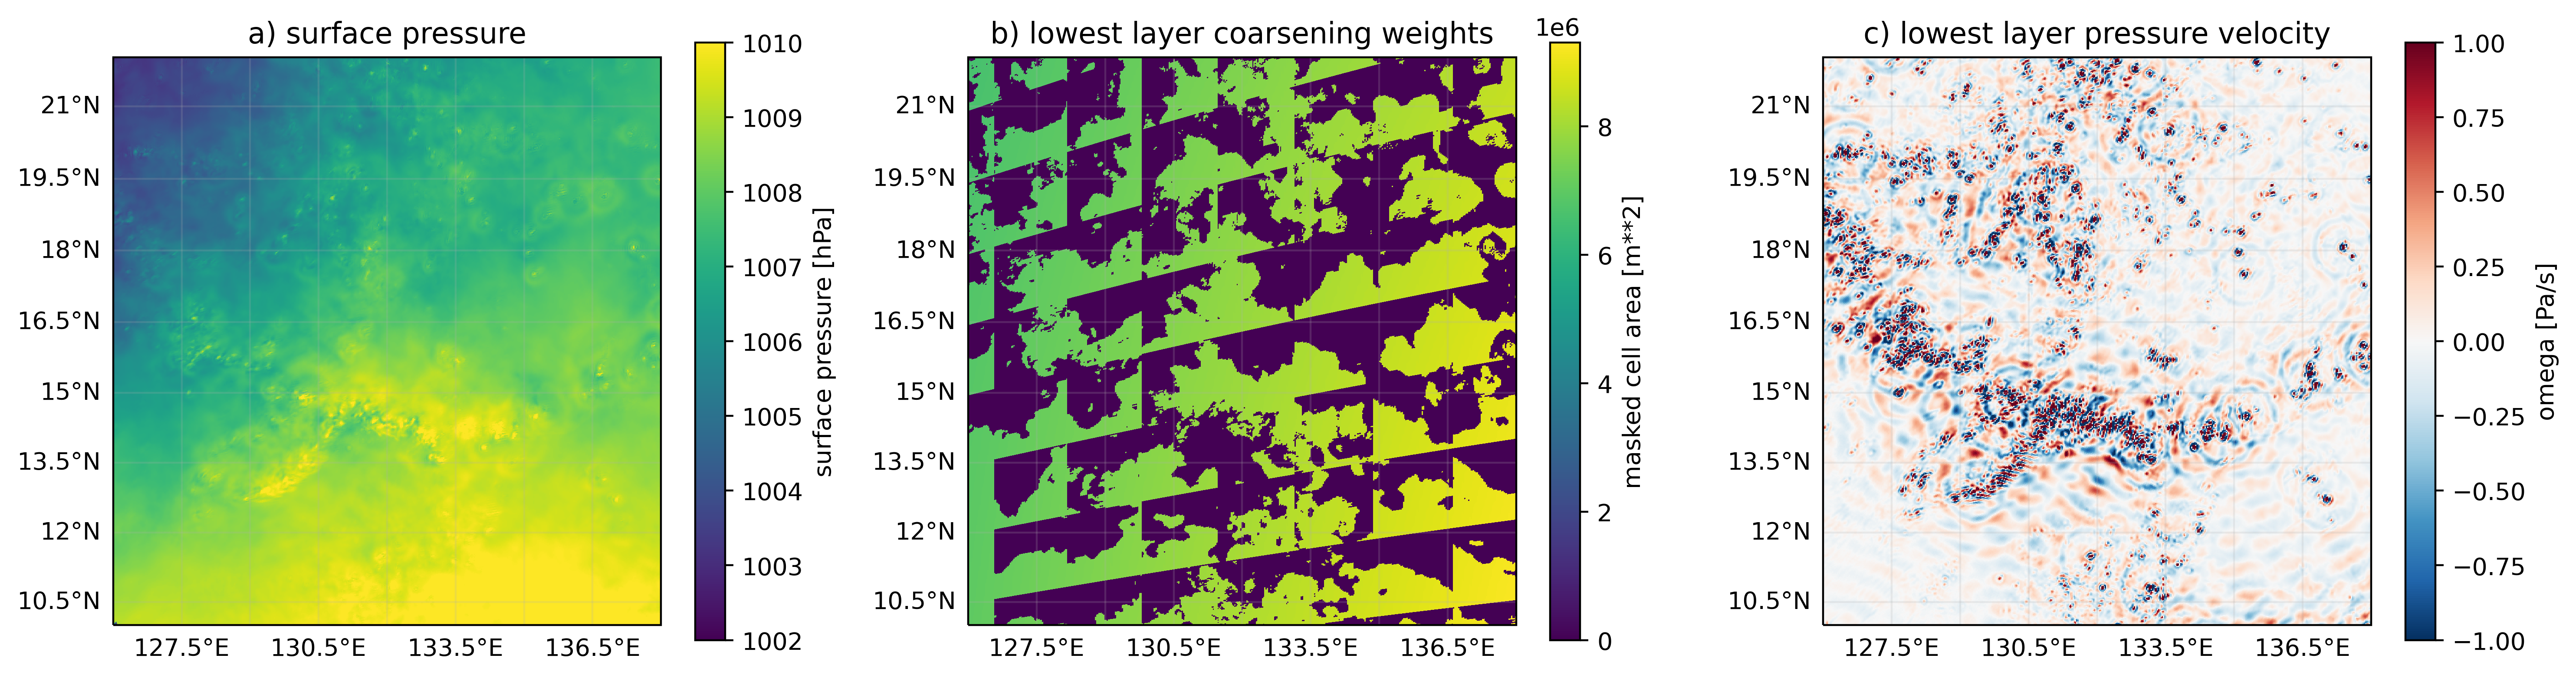

In [71]:
zone = dict(x=slice(300, 1200), y=slice(0, 500), tile=PLOT_TILE)
lat = ds.grid_latt.isel(**zone)
lon = ds.grid_lont.isel(**zone)
fig, axes = plt.subplots(1, 3, figsize=(15, 4), subplot_kw={'projection': ccrs.Mercator()})
plot_pcolormesh(axes[0], lon, lat, ds.surface_pressure_hPa.isel(**zone), vmin=1002, vmax=1010)
plot_pcolormesh(axes[1], lon, lat, masked_area.isel(z=-1, **zone))
plot_pcolormesh(axes[2], lon, lat, ds.vulcan_omega.isel(z=-1, **zone), cmap='RdBu_r', vmin=-1, vmax=1)
axes[0].set_title('a) surface pressure')
axes[1].set_title('b) lowest layer coarsening weights')
axes[2].set_title('c) lowest layer pressure velocity')
fig.tight_layout()

### Omega coarsened to C48

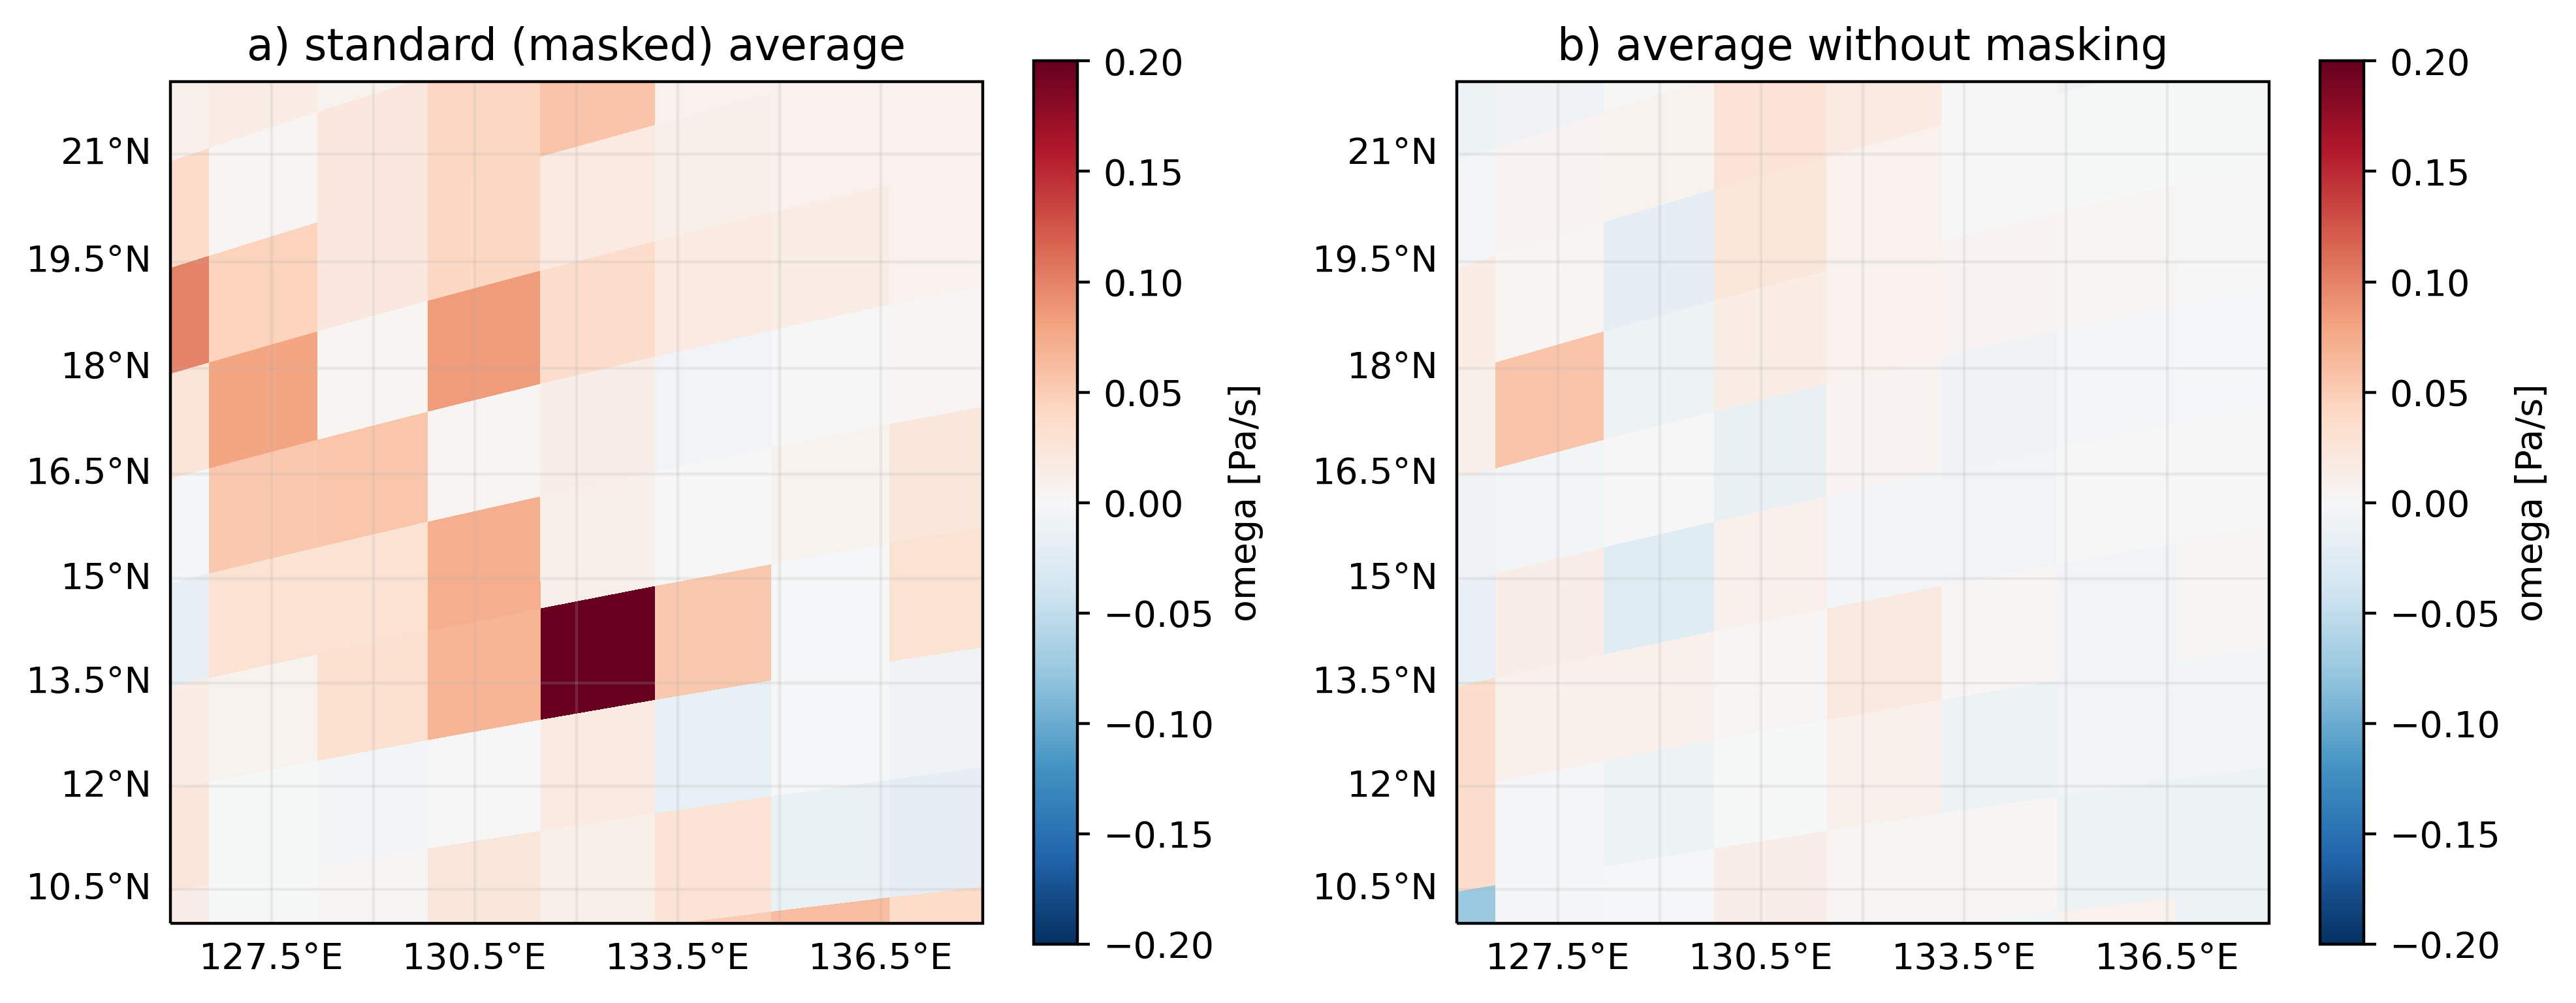

In [72]:
lat = grid_c48.lat.isel(tile=PLOT_TILE)
lon = grid_c48.lon.isel(tile=PLOT_TILE)
fig, axes = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={'projection': ccrs.Mercator()})
plot_pcolormesh(axes[0], lon, lat, ds_pressure_one_step.vulcan_omega_computed_tile3, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
plot_pcolormesh(axes[1], lon, lat, ds_pressure_one_step_unmasked.vulcan_omega_computed_tile3, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
axes[0].set_title('a) standard (masked) average')
axes[1].set_title('b) average without masking')
fig.tight_layout()

### Same, but for temperature instead of omega

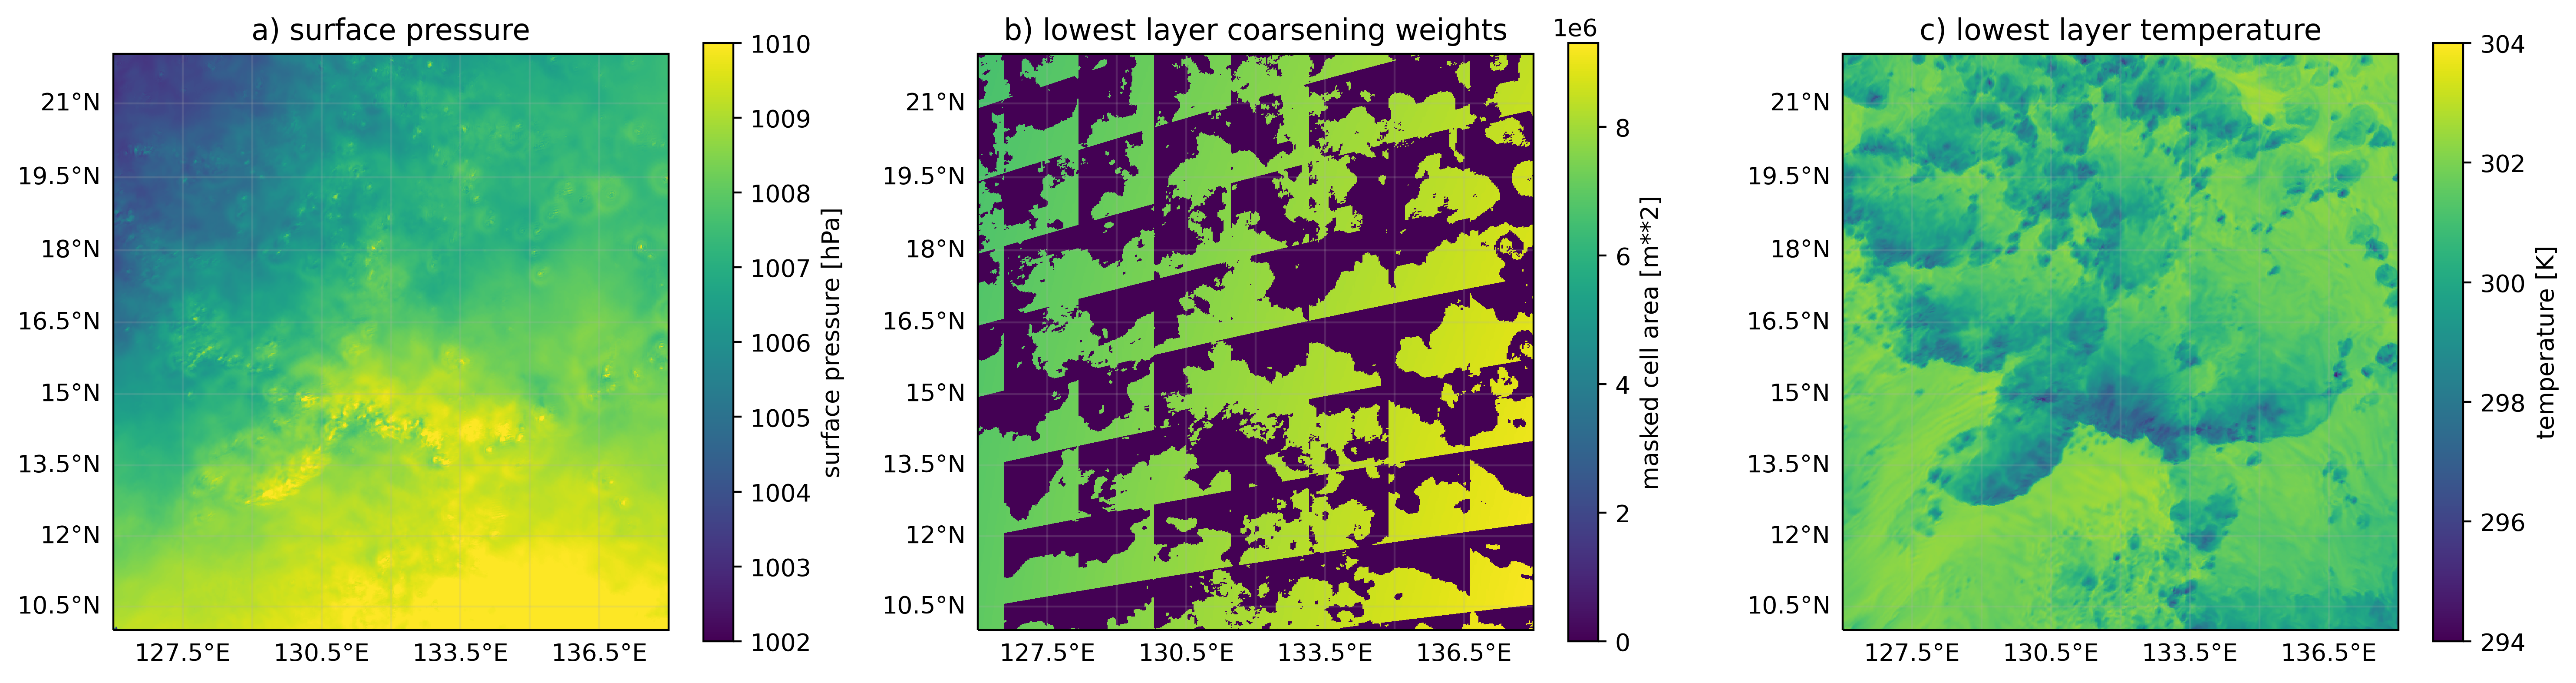

In [73]:
zone = dict(x=slice(300, 1200), y=slice(0, 500), tile=PLOT_TILE)
lat = ds.grid_latt.isel(**zone)
lon = ds.grid_lont.isel(**zone)
fig, axes = plt.subplots(1, 3, figsize=(15, 4), subplot_kw={'projection': ccrs.Mercator()})
plot_pcolormesh(axes[0], lon, lat, ds.surface_pressure_hPa.isel(**zone), vmin=1002, vmax=1010)
plot_pcolormesh(axes[1], lon, lat, masked_area.isel(z=-1, **zone))
plot_pcolormesh(axes[2], lon, lat, ds.temp.isel(z=-1, **zone), vmin=294, vmax=304)
axes[0].set_title('a) surface pressure')
axes[1].set_title('b) lowest layer coarsening weights')
axes[2].set_title('c) lowest layer temperature')
fig.tight_layout()

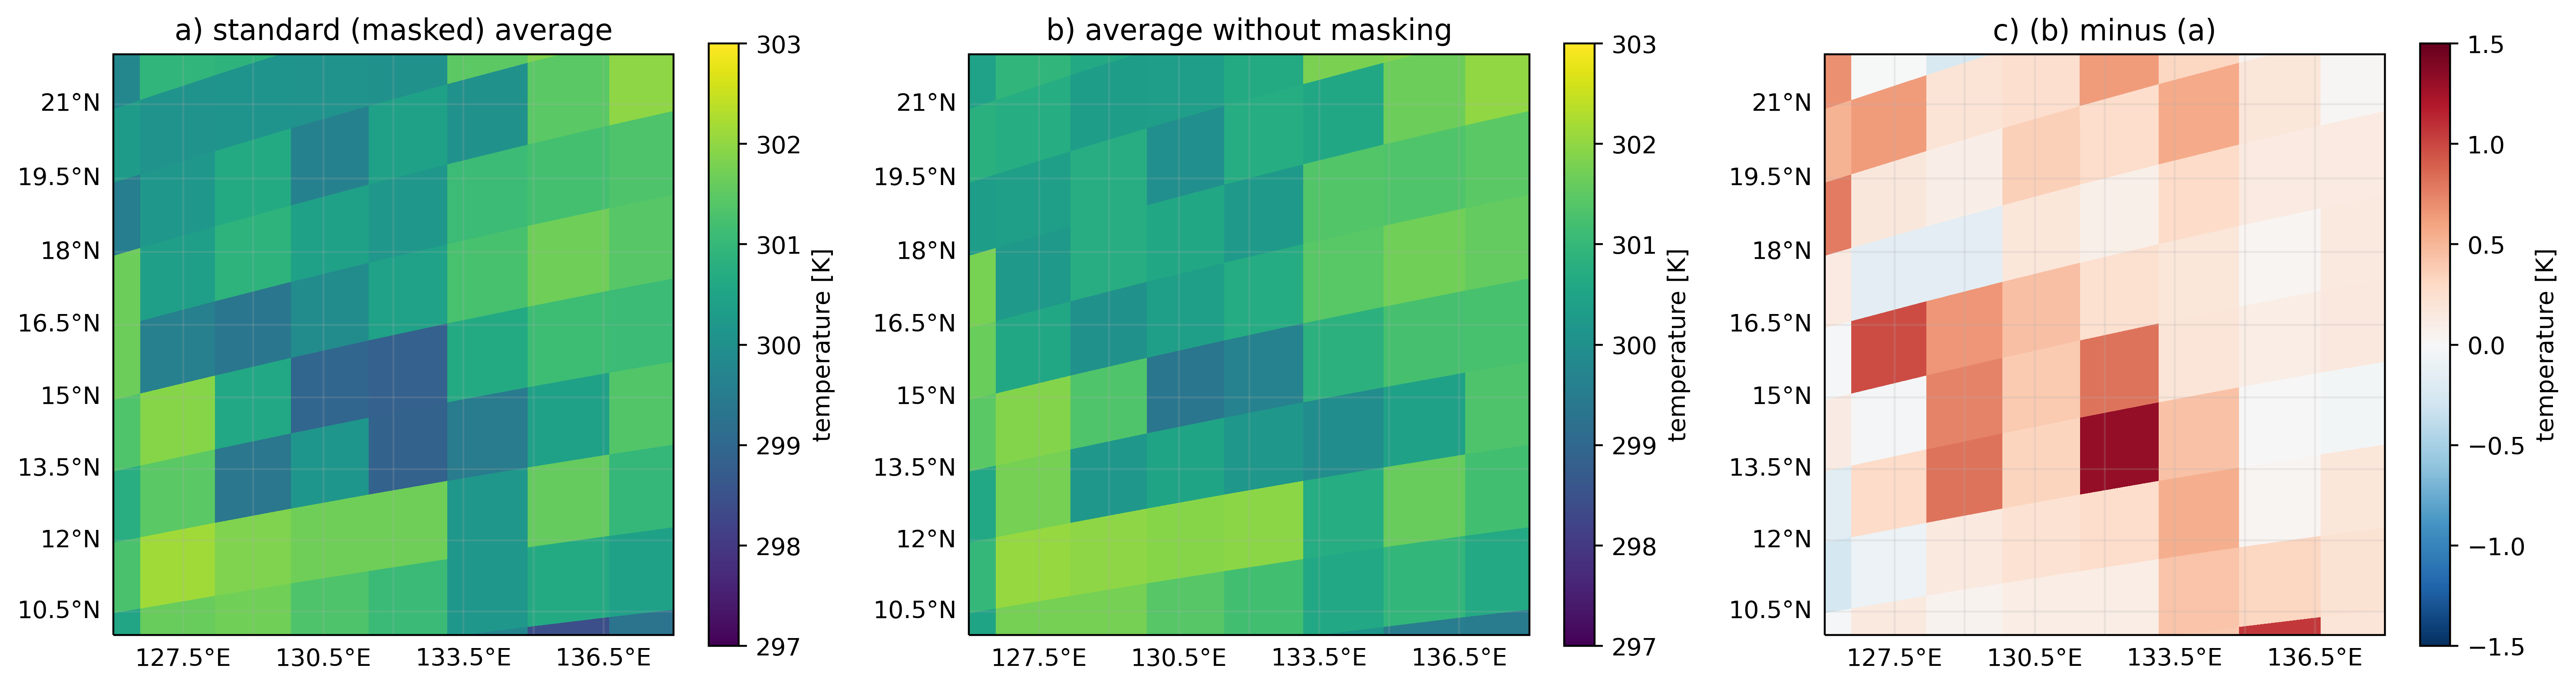

In [74]:
lat = grid_c48.lat.isel(tile=PLOT_TILE)
lon = grid_c48.lon.isel(tile=PLOT_TILE)
fig, axes = plt.subplots(1, 3, figsize=(15, 4), subplot_kw={'projection': ccrs.Mercator()})
plot_pcolormesh(axes[0], lon, lat, ds_pressure_one_step.temp_computed_tile3, vmin=297, vmax=303)
plot_pcolormesh(axes[1], lon, lat, ds_pressure_one_step_unmasked.temp_computed_tile3, vmin=297, vmax=303)
plot_pcolormesh(axes[2], lon, lat, ds_pressure_one_step_unmasked.temp_computed_tile3 - ds_pressure_one_step.temp_computed_tile3, vmin=-1.5, vmax=1.5, cmap='RdBu_r')
axes[0].set_title('a) standard (masked) average')
axes[1].set_title('b) average without masking')
axes[2].set_title('c) (b) minus (a)')
fig.tight_layout()